In [ ]:
# What about class imbalance?
from load_data import NameDataset
import json 
import torch
import matplotlib.pyplot as plt

x_data = NameDataset().x_data
y_data = NameDataset().y_data

with open("data/int_to_country.json") as file:
    int_to_country = json.load(file)


country_count = {}

for i in y_data:
    country_idx = (i == 1).nonzero(as_tuple=True)[0].item()
    country = int_to_country[str(country_idx)]
    if country not in country_count: country_count[country] = 1
    else: country_count[country] += 1

country_count = {k: v for k, v in sorted(country_count.items(), key=lambda item: item[1])}
for i, j in country_count.items():
    print(i, "\t\t", j)

In [2]:
# Load the model
import torch
rnn = torch.load("output/model.pt")

# Load the test data
from load_data import NameDataset, collate_fn

dataset = NameDataset(reduce=True)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, lengths=[11300, 1413, 1413]
)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                          collate_fn=collate_fn)


In [3]:
predictions = []
targets = []

# Iterate over the test loader and save the predictions
for idx, (x_test, y_test) in enumerate(test_loader):
    y_test = torch.argmax(y_test, dim=1)
    prediction = rnn(x_test)
    prediction = torch.argmax(prediction, dim=1)

    predictions.append(prediction)
    targets.append(y_test)

predictions = torch.cat(predictions)
targets = torch.cat(targets)

In [9]:
# Make a confusion matrix
import json
with open("data/int_to_country.json") as file:
    countries = json.load(file)

print(countries)
print(sum(predictions == targets) / len(predictions))

import torchmetrics
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4).cuda()
confmat = confmat(predictions, targets)


{'0': 'china', '1': 'italy', '2': 'thenetherlands', '3': 'usa'}
tensor(0.8273, device='cuda:0')


Text(0.5, 1.0, 'Confusion matrix')

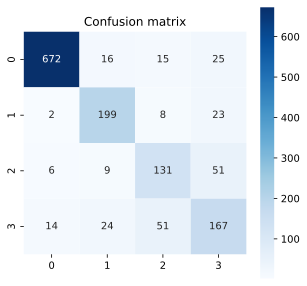

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.figure(figsize=(5, 5))
sns.heatmap(confmat.cpu(), cmap="Blues", annot=True, square=True, fmt="g")
plt.title("Confusion matrix")

In [45]:
# What names are difficult for the model to classify?
names_idx = torch.where((predictions != targets) & (predictions == 3))[0]
names_idx.shape

torch.Size([99])